<a href="https://colab.research.google.com/github/bsshreesha/Physics_Informed_Neural_Network/blob/main/Solving_PDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Use float64 for precision
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)

# Define the domain
eta = tf.linspace(0.0, 10.0, 300)[:, tf.newaxis]

In [20]:
# Neural network model
def neural_net():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(40, activation='tanh'),
        tf.keras.layers.Dense(40, activation='tanh'),
        tf.keras.layers.Dense(9, activation=None)
    ])

model = neural_net()

# Parameters
params = {
    "M": 1.0, "Pr": 1.0, "Nt": 0.5, "Nd": 0.2, "Nb": 0.4,
    "Ld": 0.1, "Lefs": 0.1, "Lnf": 0.1, "alpha": 1.0, "beta": 0.1
}

In [21]:
# ODE residuals
def compute_residuals(model, x):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y = model(x)
            y1, y2, y3, _, y5, y6, y7, y8, y9 = tf.split(y, 9, axis=1)
        dy1 = tape.gradient(y1, x)
        dy2 = tape.gradient(y2, x)
        dy3 = tape.gradient(y3, x)
        dy5 = tape.gradient(y5, x)
        dy6 = tape.gradient(y6, x)
        dy7 = tape.gradient(y7, x)
        dy8 = tape.gradient(y8, x)
        dy9 = tape.gradient(y9, x)
    del tape

    res1 = dy1 - y2
    res2 = dy2 - y3
    res3 = dy3 - (y2**2 - y1*y3 - params["M"]*y2) / (params["alpha"] + params["beta"]*y3**2)
    res4 = dy5 - y6
    res5 = dy6 + params["Pr"]*y1*y6 + params["Pr"]*params["Nb"]*y6*y9 + params["Pr"]*params["Nt"]*y5**2 + params["Nd"]*y1*y7
    res6 = dy7 - params["Lefs"]*y2 + params["Ld"]*y6
    res7 = dy8 - y9
    res8 = dy9 + (params["Nt"]/params["Nb"])*y1*y6 + params["Lnf"]*y8

    return res1, res2, res3, res4, res5, res6, res7, res8

# Loss function
def pinn_loss(model, x):
    res = compute_residuals(model, x)
    residual_loss = tf.reduce_mean(tf.square(tf.concat(res, axis=1)))
    y0 = model(tf.constant([[0.0]], dtype=tf.float64))
    y_inf = model(tf.constant([[10.0]], dtype=tf.float64))
    bc_loss = tf.reduce_mean(tf.square(y0[0, 0])) + tf.square(y0[0, 1] - 1) + tf.square(y_inf[0, 1]) + \
              tf.square(y0[0, 4] - 1) + tf.square(y_inf[0, 4]) + tf.square(y0[0, 6] - 1) + \
              tf.square(y_inf[0, 6]) + tf.square(y0[0, 7] - 1) + tf.square(y_inf[0, 7])
    return residual_loss + bc_loss

In [27]:
#Training step
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = pinn_loss(model, eta)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Train the model
for i in range(2000):
    loss = train_step()
    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.numpy()}")

# Predict
eta_test = tf.linspace(0.0, 10.0, 300)[:, tf.newaxis]
y_pred = model(eta_test).numpy()

Epoch 0, Loss: 0.002442570636048913
Epoch 100, Loss: 0.002445054706186056
Epoch 200, Loss: 0.0024420705158263445
Epoch 300, Loss: 0.0024412686470896006
Epoch 400, Loss: 0.0024404560681432486
Epoch 500, Loss: 0.002439571311697364
Epoch 600, Loss: 0.0024386008735746145
Epoch 700, Loss: 0.0024375412613153458
Epoch 800, Loss: 0.0024363913107663393
Epoch 900, Loss: 0.002435451140627265
Epoch 1000, Loss: 0.0026319981552660465
Epoch 1100, Loss: 0.0024329600855708122
Epoch 1200, Loss: 0.002432056935504079
Epoch 1300, Loss: 0.0024318627547472715
Epoch 1400, Loss: 0.002429748186841607
Epoch 1500, Loss: 0.002428882522508502
Epoch 1600, Loss: 0.0024277104530483484
Epoch 1700, Loss: 0.002426378894597292
Epoch 1800, Loss: 0.002425896003842354
Epoch 1900, Loss: 0.002424434758722782


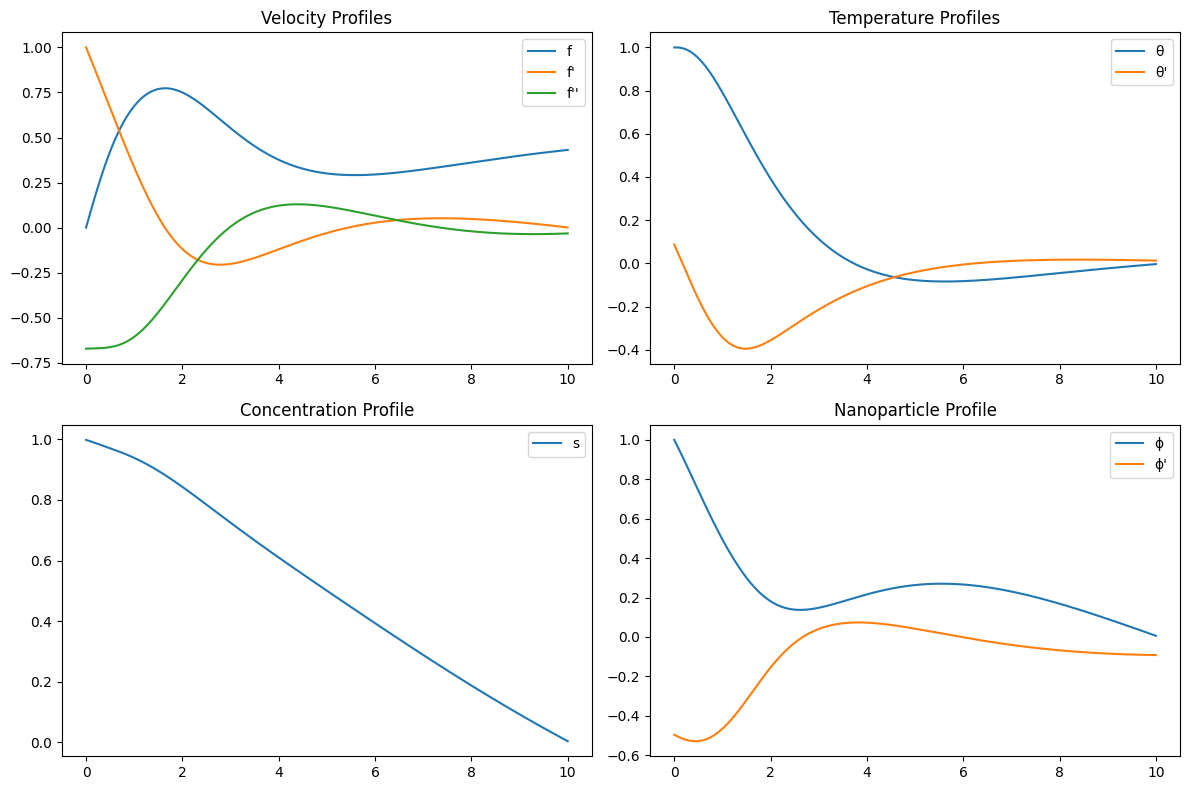

In [28]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(eta_test, y_pred[:, 0], label="f")
axs[0, 0].plot(eta_test, y_pred[:, 1], label="f'")
axs[0, 0].plot(eta_test, y_pred[:, 2], label="f''")
axs[0, 0].set_title("Velocity Profiles")
axs[0, 0].legend()

axs[0, 1].plot(eta_test, y_pred[:, 4], label="θ")
axs[0, 1].plot(eta_test, y_pred[:, 5], label="θ'")
axs[0, 1].set_title("Temperature Profiles")
axs[0, 1].legend()

axs[1, 0].plot(eta_test, y_pred[:, 6], label="s")
axs[1, 0].set_title("Concentration Profile")
axs[1, 0].legend()

axs[1, 1].plot(eta_test, y_pred[:, 7], label="ϕ")
axs[1, 1].plot(eta_test, y_pred[:, 8], label="ϕ'")
axs[1, 1].set_title("Nanoparticle Profile")
axs[1, 1].legend()

plt.tight_layout()
plt.show()